# ETF Rebalancing Algo Comparison with Investpy

Using several libraries such as PyPortfolioOpt and basic ERC to test different objectives and algorithms vs Ray Dalio all weather portfolio


In [50]:
# Library imports
import numpy as np
import pandas as pd
from pyquery import PyQuery as pq
from lxml import etree
import urllib
import datetime
from requests import Request, Session
from time import sleep
import io
import glob
from datetime import date

# Financial data import
import investpy

In [51]:
# Displaying all columns and cells in dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [52]:
# Suppress warnings where possible
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [53]:
# Preparing a list of securities to compare rebalancing performances

from io import StringIO

# Simple way for creating an editable dataframe from a csv list
csvlist =StringIO("""

name,country,symbol

Vanguard Total Stock Market,united states,VTI
iShares 20+ Year Treasury Bond,united states,TLT
iShares 7-10 Year Treasury Bond,united states,IEF
PowerShares DB Commodity Tracking,united states,DBC
SPDR Gold Shares,united states,GLD


""")
etf_list = pd.read_csv(csvlist)

In [54]:
#set empty list o hold the stock price DataFrames that we can later concatenate into a master frame
df_list = []
 
#not all stocks will return data so set up an empty list to store the stock tickers that actually successfully returns data
used_etf = []

date_start = '01/01/2016'
date_end = date.today().strftime("%d/%m/%Y")

for etf in etf_list['symbol']:
    p = etf_list.loc[etf_list['symbol'] == etf][['name','country']].values[0]
    data = investpy.get_etf_historical_data(etf=p[0],
                                    country=p[1],
                                    from_date=date_start,
                                    to_date=date_end)
    print(p[0])
    df_list.append(data['Close'])
    used_etf.append(etf)
# from pypfopt import Plotting, HRPOpt, CLA

#concatenate list of individual ticker price DataFrames into one master DataFrame
df = pd.concat(df_list,axis=1)
df.columns = used_etf

Vanguard Total Stock Market
iShares 20+ Year Treasury Bond
iShares 7-10 Year Treasury Bond
PowerShares DB Commodity Tracking
SPDR Gold Shares


In [55]:
# Section for portfolio library import

# pyportopt Analyzer

from pypfopt import HRPOpt, CLA
import matplotlib
from pypfopt import risk_models, expected_returns

from pypfopt import expected_returns
from pypfopt import risk_models

from pypfopt.efficient_frontier import EfficientFrontier

# Equal risk weighting
from erc import erc

In [56]:
# Check that head of dataframe contains data for all securities

df.head(10)

,VTI,TLT,IEF,DBC,GLD
Date,,,,,
2016-01-04,102.74,121.45,106.04,13.26,102.89
2016-01-05,102.97,120.96,106.01,13.13,103.18
2016-01-06,101.59,122.59,106.65,12.92,104.67
2016-01-07,99.10,122.81,106.88,12.86,106.15
2016-01-08,97.97,123.36,107.15,12.80,105.68
2016-01-11,97.91,122.01,106.81,12.45,104.74
2016-01-12,98.58,123.77,107.29,12.37,104.21
2016-01-13,96.04,124.99,107.71,12.30,104.72
2016-01-14,97.51,123.82,107.49,12.33,103.02


In [57]:
# Performance test for RayDalio

def get_weights_RayDalio(data):
    weights = [0.3, 0.4, 0.15, 0.075, 0.075]
    return weights


In [58]:
# Performance test for ERC

def get_weights_ercsample(data):
    S = risk_models.sample_cov(data)
    try:
        res = erc.calc_weights(S, pcr_tolerance=0.01)
        weights = res
    except:
        weights = pd.DataFrame(np.zeros((0, 0)))
    return weights


In [59]:
# Performance test for ERC

def get_weights_ercexpcovspan(data):
    S = risk_models.exp_cov(data, span=44 )
    try:
        res = erc.calc_weights(S, pcr_tolerance=0.01)
        weights = res
    except:
        weights = pd.DataFrame(np.zeros((0, 0)))
    return weights


In [60]:
# Performance test for HRP

def get_weights_hrp(data):
    returns = data.pct_change()
    if len(returns > 0):
        hrp = HRPOpt(returns)
        weights = hrp.optimize()
    else:
        weights = pd.DataFrame(np.zeros((0, 0)))
    return weights

In [61]:
def get_weights_hrp(data):
    returns = data.pct_change()
    if len(returns > 0):
        hrp = HRPOpt(returns)
        weights = hrp.optimize()
    else:
        weights = pd.DataFrame(np.zeros((0, 0)))
    return weights

In [62]:
# Exponential Cov Matrix

def get_weights_exp(data):
    S = risk_models.exp_cov(data)
    ef = EfficientFrontier(None, S)
    weights = ef.min_volatility()
    return weights

In [63]:
# Exponential Cov Matrix span

def get_weights_expspan(data):
    S = risk_models.exp_cov(data, span=44 )
    ef = EfficientFrontier(None, S)
    weights = ef.min_volatility()
    return weights

In [64]:
# Exponential Cov Matrix span and max sharpe


def get_weights_get_weights_expsharpe(data):
    mean_return = expected_returns.mean_historical_return(data)
    try:
        S = risk_models.exp_cov(data, span=44)
        ef = EfficientFrontier(mean_return, S)
        weights = ef.max_sharpe()
    except:
        weights = pd.DataFrame(np.zeros((0, 0)))
    return weights


In [65]:
# Exponential Lwolf span and max sharpe

def get_weights_lwolf(data):
    mean_return = expected_returns.mean_historical_return(data)
    try:
        S = risk_models.CovarianceShrinkage(data).ledoit_wolf()
        ef = EfficientFrontier(mean_return, S)
        weights = ef.max_sharpe()
    except:
        weights = pd.DataFrame(np.zeros((0, 0)))
    return weights

In [66]:
# Exponential Lwolf minvol

def get_weights_lwolfminvol(data):
    S = risk_models.CovarianceShrinkage(data).ledoit_wolf()
    ef = EfficientFrontier(None, S)
    weights = ef.min_volatility()
    return weights

NoneType: None
NoneType: None


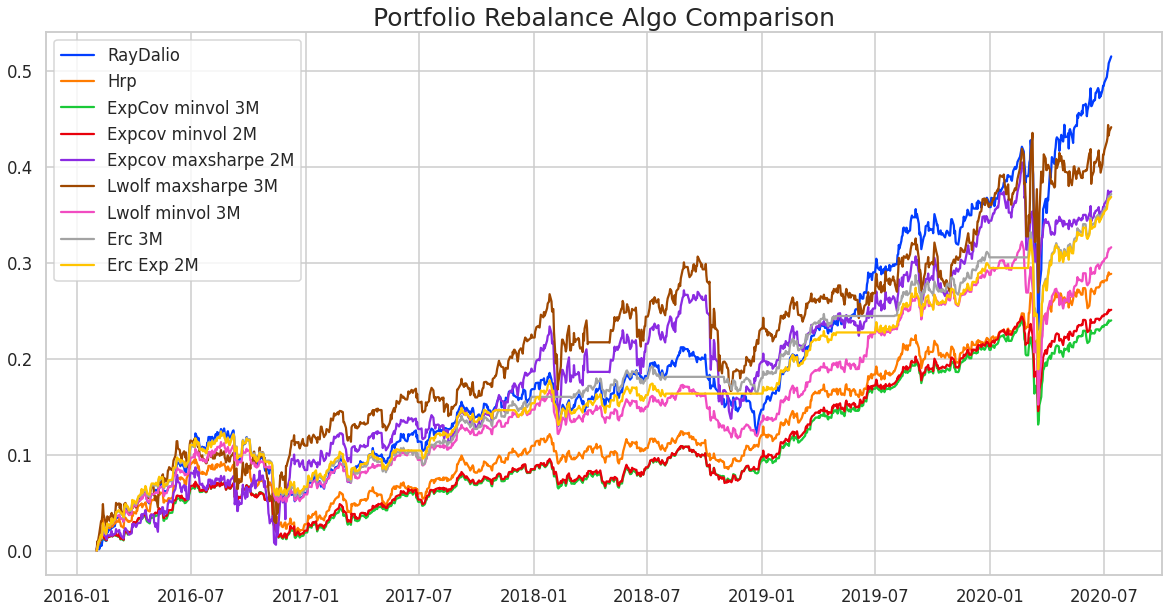

In [68]:
from datetime import datetime, timedelta 
import calendar

data = df.copy()
data.dropna(inplace=True)

# lookback window for correlation analysis
monthdays = 22*3

months = [1,2,3,4,5,6,7,8,9,10,11,12]
years = [2016,2017,2018,2019,2020]

def backtest_portfolio_rebalance(df2, get_weights):
    # Creating an empty Dataframe
    portfolio_rtn_df = pd.DataFrame(np.zeros((0, 0)))
    portfolio_cum_rtn_df = pd.DataFrame(np.zeros((0, 0)))

    for year in years:
        for month in months:
            monthly = df2.loc[(df2.index >= pd.to_datetime(str(year)+'-'+str(month)+'-1') - timedelta(days=monthdays)) & (df2.index < str(year)+'-'+str(month)+'-1')]
            prices = df2.loc[(df2.index >= pd.to_datetime(str(year)+'-'+str(month)+'-1')) & (df2.index <= str(year)+'-'+str(month)+'-'+str(calendar.monthrange(year,month)[1]))]
            if len(monthly > 0):
                weights = get_weights(monthly)
                portfolio_rtn_df = portfolio_rtn_df.append((weights*prices.pct_change().fillna(0)))

    portfolio_cum_rtn_df = (1 + portfolio_rtn_df.sum(axis=1)).cumprod() - 1
    return portfolio_cum_rtn_df

import matplotlib.pyplot as plt
import seaborn as sns

rayd  = backtest_portfolio_rebalance(data, get_weights_RayDalio)
hrp   = backtest_portfolio_rebalance(data, get_weights_hrp)
exp1  = backtest_portfolio_rebalance(data, get_weights_exp)
exp2  = backtest_portfolio_rebalance(data, get_weights_expspan)
exp3  = backtest_portfolio_rebalance(data, get_weights_get_weights_expsharpe)
lwolf = backtest_portfolio_rebalance(data, get_weights_lwolf)
lwolf2 = backtest_portfolio_rebalance(data, get_weights_lwolfminvol)
erc1 = backtest_portfolio_rebalance(data, get_weights_ercsample)
erc2 = backtest_portfolio_rebalance(data, get_weights_ercexpcovspan)


sns.set(style='whitegrid', context='talk', palette='bright')
plt.figure(figsize=(20,10))
plt.plot(

        rayd.index, rayd,
        hrp.index, hrp, 
        exp1.index, exp1,
        exp2.index, exp2,
        exp3.index, exp3,
        lwolf.index, lwolf,
        lwolf2.index, lwolf2,
        erc1.index, erc1,
        erc2.index, erc2,
)

plt.legend(['RayDalio', 'Hrp', 'ExpCov minvol 3M', 'Expcov minvol 2M', 'Expcov maxsharpe 2M', 'Lwolf maxsharpe 3M', 'Lwolf minvol 3M', 'Erc 3M', 'Erc Exp 2M'], loc='upper left')

plt.title('Portfolio Rebalance Algo Comparison', fontsize=25)

plt.show()
